# CGAN

*Conditional GAN*

条件付きGAN。与えた条件に沿った画像を生成する。  
「条件」を表すベクトルをGenerator, Discriminatorの両方に与える。与え方はいろいろある。

MNISTを使って、指定した数字の手書き数字画像を生成する

In [1]:
# パッケージのimport
# パッケージのimport
import random
import math
import time
import pandas as pd
import numpy as np
from PIL import Image

import torch
import torch.utils.data as data
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import transforms
from torch.utils.data import DataLoader
import torchvision
from torchvision import transforms
from IPython.display import display
from typing import List, Tuple

# Setup seeds
torch.manual_seed(1234)
np.random.seed(1234)
random.seed(1234)

nz = 40
noise_std = 0.5
dropout_ratio = 0.3
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [2]:
# for google colab

from google.colab import drive
drive.mount('/content/drive')

path = "/content/drive/MyDrive/Colab Notebooks/GenerativeAI/"

# for local runtime
# path = "./Desktop/generative_ai/"

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Dataloaderの作成

In [3]:
def make_datapath_list():
    """学習、検証の画像データとアノテーションデータへのファイルパスリストを作成する。 """

    train_img_list = list()  # 画像ファイルパスを格納

    for img_idx in range(50):
        img_path = path + "data/hemangioma_cropped/hemangioma_cropped_" + str(img_idx)+'.png'
        train_img_list.append({"data":img_path, "label":0})

        img_path = path + "data/metastasis_cropped/metastasis_cropped_" + str(img_idx)+'.png'
        train_img_list.append({"data":img_path, "label":1})

    return train_img_list

class ImageTransform():
    """画像の前処理クラス"""

    def __init__(self, mean, std):
        self.data_transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize(mean, std)
        ])

    def __call__(self, img):
        return self.data_transform(img)

class GAN_Img_Dataset(data.Dataset):
    def __init__(self, datalist, transform):
        self.transform = transform
        # TODO: fix to original data
        self.datalist = datalist

    # ここで取り出すデータを指定している
    def __getitem__(
        self,
        index: int
    ) -> Tuple[torch.Tensor, torch.Tensor]:
        datapath = self.datalist[index]["data"]
        label = self.datalist[index]["label"]

        img = Image.open(datapath)

        # データの変形 (transforms)
        img_transformed = self.transform(img)

        return img_transformed, label

    def __len__(self) -> int:
        return len(self.datalist)

mean = (0.5,)
std = (0.5,)
batch_size = 25

dataset = GAN_Img_Dataset(
    # TODO: fix to your original
    datalist=make_datapath_list(),
    transform=ImageTransform(mean, std)
)

train_dataloader = DataLoader(
    dataset=dataset,
    batch_size=batch_size,
    shuffle=True
)

# 動作の確認
sample_x, _ = next(iter(train_dataloader))
n_classes = 2 # hem: 0, met: 1の2クラス
w, h = sample_x.shape[-2:]
image_size = w * h
print("batch shape:", sample_x.shape)
print("width:", w)
print("height:", h)
print("image size:", image_size)
print("num classes:", n_classes)

batch shape: torch.Size([25, 1, 64, 64])
width: 64
height: 64
image size: 4096
num classes: 2


## 条件の埋め込み

条件の情報をノイズに埋め込む。対応する部分だけ少し大きな値をとるようにした。

In [4]:
eye = torch.eye(n_classes, device=device)
def make_noise(labels):
    labels = eye[labels]
    labels = labels.repeat_interleave(nz // n_classes, dim=-1)
    z = torch.normal(0, noise_std, size=(len(labels), nz), device=device)
    z = z + labels
    return z

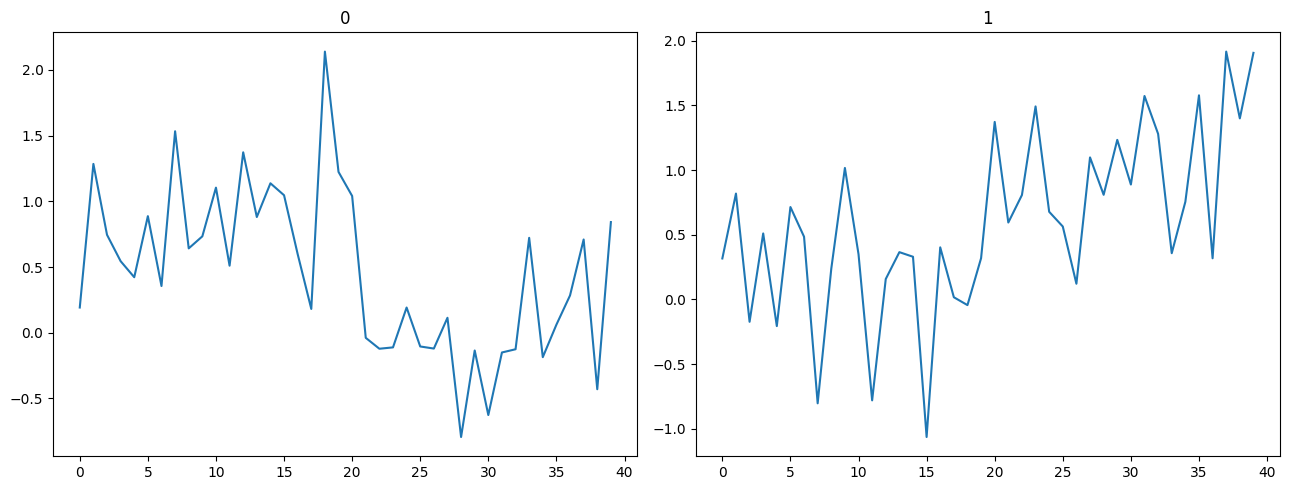

In [5]:
import matplotlib.pyplot as plt

plt.figure(figsize=(13, 5))
for label in range(n_classes):
    plt.subplot(1, 2, label+1)
    vec = make_noise(torch.tensor([label])).cpu().numpy().ravel()
    plt.plot(vec)
    plt.title(label)
plt.tight_layout()

## 学習

In [6]:
# 画像描画
def write(netG, n_rows=1, size=64):
    n_images = n_rows * n_classes
    z = make_noise(torch.tensor(list(range(n_classes)) * n_rows))
    images = netG(z)
    images = transforms.Resize(size)(images)
    img = torchvision.utils.make_grid(images, n_images // n_rows)
    img = transforms.functional.to_pil_image(img)
    display(img)

# 間違ったラベルの生成
def make_false_labels(labels):
    diff = torch.randint(1, n_classes, size=labels.size(), device=device)
    fake_labels = (labels + diff) % n_classes
    return fake_labels

In [7]:
fake_labels = torch.zeros(batch_size, 1).to(device)
real_labels = torch.ones(batch_size, 1).to(device)
criterion = nn.BCEWithLogitsLoss(reduction='mean')

def train(netD, netG, n_epochs, write_interval=1):
    # 学習モード
    netD.train()
    netG.train()

    # optimizerを選択
    g_lr, d_lr = 0.0001, 0.0004
    beta1, beta2 = 0.0, 0.9
    optimD = optim.Adam(netD.parameters(), g_lr, [beta1, beta2])
    optimG = optim.Adam(netG.parameters(), d_lr, [beta1, beta2])


    for epoch in range(1, n_epochs+1):

        # 開始時刻を保存
        t_epoch_start = time.time()
        epoch_g_loss = 0.0  # epochの損失和
        epoch_d_loss = 0.0  # epochの損失和

        for X, labels in train_dataloader:
            X = X.to(device) # 本物の画像
            labels = labels.flatten()
            labels = labels.to(device) # 正しいラベル
            false_labels = make_false_labels(labels) # 間違ったラベル

            # 勾配をリセット
            optimD.zero_grad()
            optimG.zero_grad()

            # Discriminatorの学習
            z = make_noise(labels) # ノイズを生成
            fake = netG(z) # 偽物を生成
            pred_fake = netD(fake, labels) # 偽物を判定
            pred_real_true = netD(X, labels) # 本物&正しいラベルを判定
            pred_real_false = netD(X, false_labels) # 本物&間違ったラベルを判定
            # 誤差を計算
            loss_fake = criterion(pred_fake, fake_labels)
            loss_real_true = criterion(pred_real_true, real_labels)
            loss_real_false = criterion(pred_real_false, fake_labels)
            lossD = loss_fake + loss_real_true + loss_real_false
            lossD.backward() # 逆伝播
            optimD.step() # パラメータ更新

            # Generatorの学習
            fake = netG(z) # 偽物を生成
            pred = netD(fake, labels) # 偽物を判定
            lossG = criterion(pred, real_labels) # 誤差を計算
            lossG.backward() # 逆伝播
            optimG.step() # パラメータ更新


        t_epoch_finish = time.time()
        print('-------------')
        print(f'{epoch:>3}epoch | lossD: {lossD:.4f}, lossG: {lossG:.4f}')
        print('timer:  {:.4f} sec.'.format(t_epoch_finish - t_epoch_start))
        t_epoch_start = time.time()

        if write_interval and epoch % write_interval == 0:
            write(netG)

## CDCGAN

*Conditional Deep Convolitional GAN*

条件付きDCGAN。GeneratorとDiscriminatorにCNNを使うだけ。画像がきれいになることを期待する。

### Discriminator

畳み込みで得た特徴ベクトルに、ラベル（条件）のone-hotベクトルを結合して、全結合層に入力する。

In [8]:
class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv = nn.Sequential(
            self._conv_layer(1, w, 4, 2, 1),
            self._conv_layer(w, w*2, 4, 2, 1),
            self._conv_layer(w*2, w*4, 4, 2, 1),
            self._conv_layer(w*4, w*8, 4, 2, 1),
            nn.Conv2d(w*8, w*16, 4, 1, 0),
            nn.Flatten()
        )

        self.fc = nn.Sequential(
            nn.Linear(w*16 + n_classes, 64),
            nn.ReLU(inplace=True),
            nn.Linear(64, 1),
            nn.Sigmoid()
        )

        self._eye = torch.eye(n_classes, device=device) # 条件ベクトル生成用の単位行列

    def _conv_layer(self, in_channels, out_channels, kernel_size, stride, padding):
        return nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding),
            nn.BatchNorm2d(out_channels),
            nn.LeakyReLU(0.1, inplace=True),
            nn.Dropout(p=dropout_ratio)
        )

    def forward(self, x, labels):
        x = self.conv(x) # 特徴抽出
        labels = labels.flatten()
        labels = self._eye[labels] # 条件(ラベル)をone-hotベクトルに
        x = torch.cat([x, labels], dim=1) # 画像と条件を結合
        y = self.fc(x)
        return y

### Generator

先ほど同様、条件の情報はノイズに持たせる。

In [9]:
class Generator(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            self._convT(nz, w*8, 4, 1, 0),
            self._convT(w*8, w*4, 4, 2, 1),
            self._convT(w*4, w*2, 4, 2, 1),
            self._convT(w*2, w, 4, 2, 1),
            nn.ConvTranspose2d(w, 1, 4, 2, 1),
            nn.Sigmoid()
        )

    def _convT(self, in_channels, out_channels, kernel_size, stride, padding):
        return nn.Sequential(
            nn.ConvTranspose2d(in_channels, out_channels, kernel_size, stride, padding),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        x = x.view(-1, nz, 1, 1)
        y = self.net(x)
        return y

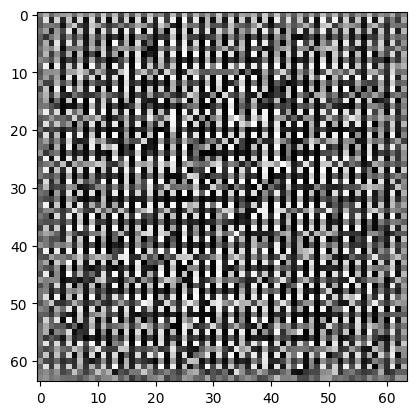

In [10]:
# 動作確認
import matplotlib.pyplot as plt
%matplotlib inline

G = Generator()

# 入力する乱数
input_z = torch.randn(1, nz)

# テンソルサイズを(1, z_dim, 1, 1)に変形
input_z = input_z.view(input_z.size(0), input_z.size(1), 1, 1)

# 偽画像を出力
fake_images = G(input_z)

img_transformed = fake_images[0][0].detach().numpy()
plt.imshow(img_transformed, 'gray')
plt.show()


### 学習

初期状態


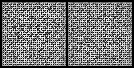

-------------
  1epoch | lossD: 2.0915, lossG: 0.6865
timer:  1.2091 sec.
-------------
  2epoch | lossD: 2.0838, lossG: 0.6907
timer:  0.5250 sec.
-------------
  3epoch | lossD: 2.0810, lossG: 0.6920
timer:  0.4569 sec.
-------------
  4epoch | lossD: 2.0806, lossG: 0.6925
timer:  0.4630 sec.
-------------
  5epoch | lossD: 2.0802, lossG: 0.6927
timer:  0.5527 sec.
-------------
  6epoch | lossD: 2.0795, lossG: 0.6928
timer:  0.5085 sec.
-------------
  7epoch | lossD: 2.0799, lossG: 0.6929
timer:  0.4663 sec.
-------------
  8epoch | lossD: 2.0795, lossG: 0.6930
timer:  0.4381 sec.
-------------
  9epoch | lossD: 2.0796, lossG: 0.6930
timer:  0.4564 sec.
-------------
 10epoch | lossD: 2.0795, lossG: 0.6931
timer:  0.4851 sec.
-------------
 11epoch | lossD: 2.0795, lossG: 0.6931
timer:  0.4899 sec.
-------------
 12epoch | lossD: 2.0794, lossG: 0.6931
timer:  0.5859 sec.
-------------
 13epoch | lossD: 2.0796, lossG: 0.6931
timer:  0.6235 sec.
-------------
 14epoch | lossD: 2.0794

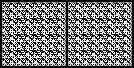

-------------
101epoch | lossD: 2.0794, lossG: 0.6931
timer:  0.4115 sec.
-------------
102epoch | lossD: 2.0794, lossG: 0.6931
timer:  0.4144 sec.
-------------
103epoch | lossD: 2.0794, lossG: 0.6931
timer:  0.4159 sec.
-------------
104epoch | lossD: 2.0791, lossG: 0.6931
timer:  0.4360 sec.
-------------
105epoch | lossD: 2.0794, lossG: 0.6931
timer:  0.4680 sec.
-------------
106epoch | lossD: 2.0794, lossG: 0.6931
timer:  0.4926 sec.
-------------
107epoch | lossD: 2.0794, lossG: 0.6931
timer:  0.4251 sec.
-------------
108epoch | lossD: 2.0795, lossG: 0.6931
timer:  0.4091 sec.
-------------
109epoch | lossD: 2.0794, lossG: 0.6931
timer:  0.4162 sec.
-------------
110epoch | lossD: 2.0794, lossG: 0.6931
timer:  0.4120 sec.
-------------
111epoch | lossD: 2.0795, lossG: 0.6931
timer:  0.4150 sec.
-------------
112epoch | lossD: 2.0793, lossG: 0.6931
timer:  0.4277 sec.
-------------
113epoch | lossD: 2.0795, lossG: 0.6931
timer:  0.4886 sec.
-------------
114epoch | lossD: 2.0794

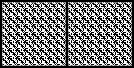

-------------
201epoch | lossD: 2.0790, lossG: 0.6931
timer:  0.4284 sec.
-------------
202epoch | lossD: 2.0769, lossG: 0.6931
timer:  0.4233 sec.
-------------
203epoch | lossD: 2.0788, lossG: 0.6931
timer:  0.4431 sec.
-------------
204epoch | lossD: 2.0725, lossG: 0.6931
timer:  0.5336 sec.
-------------
205epoch | lossD: 2.0776, lossG: 0.6931
timer:  0.5662 sec.
-------------
206epoch | lossD: 2.0759, lossG: 0.6931
timer:  0.6117 sec.
-------------
207epoch | lossD: 2.0810, lossG: 0.6931
timer:  0.4432 sec.
-------------
208epoch | lossD: 2.0786, lossG: 0.6931
timer:  0.4279 sec.
-------------
209epoch | lossD: 2.0757, lossG: 0.6931
timer:  0.4339 sec.
-------------
210epoch | lossD: 2.0778, lossG: 0.6931
timer:  0.4417 sec.
-------------
211epoch | lossD: 2.0715, lossG: 0.6931
timer:  0.4515 sec.
-------------
212epoch | lossD: 2.0764, lossG: 0.6931
timer:  0.4430 sec.
-------------
213epoch | lossD: 2.0709, lossG: 0.6931
timer:  0.4529 sec.
-------------
214epoch | lossD: 2.0869

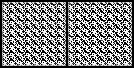

-------------
301epoch | lossD: 2.0714, lossG: 0.6931
timer:  0.4187 sec.
-------------
302epoch | lossD: 2.0543, lossG: 0.6931
timer:  0.4207 sec.
-------------
303epoch | lossD: 2.0526, lossG: 0.6931
timer:  0.4173 sec.
-------------
304epoch | lossD: 2.0601, lossG: 0.6931
timer:  0.4185 sec.
-------------
305epoch | lossD: 2.0704, lossG: 0.6931
timer:  0.4200 sec.
-------------
306epoch | lossD: 2.0629, lossG: 0.6931
timer:  0.4329 sec.
-------------
307epoch | lossD: 2.0642, lossG: 0.6931
timer:  0.4289 sec.
-------------
308epoch | lossD: 2.0624, lossG: 0.6931
timer:  0.4277 sec.
-------------
309epoch | lossD: 2.0696, lossG: 0.6931
timer:  0.4383 sec.
-------------
310epoch | lossD: 2.0703, lossG: 0.6931
timer:  0.4495 sec.
-------------
311epoch | lossD: 2.0677, lossG: 0.6931
timer:  0.4224 sec.
-------------
312epoch | lossD: 2.0599, lossG: 0.6931
timer:  0.4212 sec.
-------------
313epoch | lossD: 2.0577, lossG: 0.6931
timer:  0.4224 sec.
-------------
314epoch | lossD: 2.0519

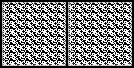

-------------
401epoch | lossD: 2.0362, lossG: 0.6931
timer:  0.4710 sec.
-------------
402epoch | lossD: 2.0236, lossG: 0.6931
timer:  0.4377 sec.
-------------
403epoch | lossD: 2.0349, lossG: 0.6931
timer:  0.4909 sec.
-------------
404epoch | lossD: 2.0319, lossG: 0.6931
timer:  0.4600 sec.
-------------
405epoch | lossD: 2.0482, lossG: 0.6931
timer:  0.4586 sec.
-------------
406epoch | lossD: 2.0427, lossG: 0.6931
timer:  0.4176 sec.
-------------
407epoch | lossD: 2.0587, lossG: 0.6931
timer:  0.4200 sec.
-------------
408epoch | lossD: 2.0331, lossG: 0.6931
timer:  0.4210 sec.
-------------
409epoch | lossD: 2.0440, lossG: 0.6931
timer:  0.4221 sec.
-------------
410epoch | lossD: 2.0502, lossG: 0.6931
timer:  0.4383 sec.
-------------
411epoch | lossD: 2.0256, lossG: 0.6931
timer:  0.4196 sec.
-------------
412epoch | lossD: 2.0220, lossG: 0.6931
timer:  0.4196 sec.
-------------
413epoch | lossD: 2.0336, lossG: 0.6931
timer:  0.4861 sec.
-------------
414epoch | lossD: 2.0248

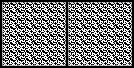

-------------
501epoch | lossD: 1.9679, lossG: 0.6931
timer:  0.4314 sec.
-------------
502epoch | lossD: 2.0247, lossG: 0.6931
timer:  0.4277 sec.
-------------
503epoch | lossD: 1.9890, lossG: 0.6931
timer:  0.4276 sec.
-------------
504epoch | lossD: 1.9996, lossG: 0.6931
timer:  0.4272 sec.
-------------
505epoch | lossD: 1.9995, lossG: 0.6931
timer:  0.4241 sec.
-------------
506epoch | lossD: 2.0155, lossG: 0.6931
timer:  0.4196 sec.
-------------
507epoch | lossD: 2.0013, lossG: 0.6931
timer:  0.4244 sec.
-------------
508epoch | lossD: 1.9870, lossG: 0.6931
timer:  0.4273 sec.
-------------
509epoch | lossD: 1.9999, lossG: 0.6931
timer:  0.4238 sec.
-------------
510epoch | lossD: 2.0122, lossG: 0.6931
timer:  0.4245 sec.
-------------
511epoch | lossD: 2.0086, lossG: 0.6931
timer:  0.4144 sec.
-------------
512epoch | lossD: 2.0239, lossG: 0.6931
timer:  0.4252 sec.
-------------
513epoch | lossD: 2.0049, lossG: 0.6931
timer:  0.4176 sec.
-------------
514epoch | lossD: 2.0195

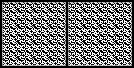

-------------
601epoch | lossD: 1.9656, lossG: 0.6931
timer:  0.4215 sec.
-------------
602epoch | lossD: 1.9424, lossG: 0.6931
timer:  0.4203 sec.
-------------
603epoch | lossD: 1.9794, lossG: 0.6931
timer:  0.4202 sec.
-------------
604epoch | lossD: 2.0024, lossG: 0.6931
timer:  0.4211 sec.
-------------
605epoch | lossD: 1.9660, lossG: 0.6931
timer:  0.4257 sec.
-------------
606epoch | lossD: 1.9933, lossG: 0.6931
timer:  0.4219 sec.
-------------
607epoch | lossD: 1.9580, lossG: 0.6931
timer:  0.4193 sec.
-------------
608epoch | lossD: 1.9581, lossG: 0.6931
timer:  0.4160 sec.
-------------
609epoch | lossD: 2.0017, lossG: 0.6931
timer:  0.4169 sec.
-------------
610epoch | lossD: 1.9517, lossG: 0.6931
timer:  0.4206 sec.
-------------
611epoch | lossD: 1.9666, lossG: 0.6931
timer:  0.4262 sec.
-------------
612epoch | lossD: 1.9747, lossG: 0.6931
timer:  0.4360 sec.
-------------
613epoch | lossD: 1.9643, lossG: 0.6931
timer:  0.4216 sec.
-------------
614epoch | lossD: 1.9301

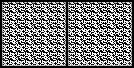

-------------
701epoch | lossD: 1.9835, lossG: 0.6931
timer:  0.4249 sec.
-------------
702epoch | lossD: 1.9111, lossG: 0.6931
timer:  0.4254 sec.
-------------
703epoch | lossD: 1.9506, lossG: 0.6931
timer:  0.4257 sec.
-------------
704epoch | lossD: 1.9716, lossG: 0.6931
timer:  0.4162 sec.
-------------
705epoch | lossD: 1.9487, lossG: 0.6931
timer:  0.4191 sec.
-------------
706epoch | lossD: 1.9490, lossG: 0.6931
timer:  0.4142 sec.
-------------
707epoch | lossD: 1.9272, lossG: 0.6931
timer:  0.4167 sec.
-------------
708epoch | lossD: 1.9050, lossG: 0.6931
timer:  0.4185 sec.
-------------
709epoch | lossD: 1.9348, lossG: 0.6931
timer:  0.4173 sec.
-------------
710epoch | lossD: 1.9628, lossG: 0.6931
timer:  0.4189 sec.
-------------
711epoch | lossD: 1.9576, lossG: 0.6931
timer:  0.4171 sec.
-------------
712epoch | lossD: 1.9458, lossG: 0.6931
timer:  0.4139 sec.
-------------
713epoch | lossD: 1.9503, lossG: 0.6931
timer:  0.4197 sec.
-------------
714epoch | lossD: 1.9911

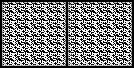

-------------
801epoch | lossD: 1.9281, lossG: 0.6931
timer:  0.4209 sec.
-------------
802epoch | lossD: 1.9280, lossG: 0.6931
timer:  0.4150 sec.
-------------
803epoch | lossD: 1.9401, lossG: 0.6931
timer:  0.4148 sec.
-------------
804epoch | lossD: 1.9395, lossG: 0.6931
timer:  0.4169 sec.
-------------
805epoch | lossD: 1.9908, lossG: 0.6931
timer:  0.4191 sec.
-------------
806epoch | lossD: 1.9277, lossG: 0.6931
timer:  0.4189 sec.
-------------
807epoch | lossD: 1.9182, lossG: 0.6931
timer:  0.4229 sec.
-------------
808epoch | lossD: 1.9138, lossG: 0.6931
timer:  0.4238 sec.
-------------
809epoch | lossD: 1.9520, lossG: 0.6931
timer:  0.4229 sec.
-------------
810epoch | lossD: 1.9517, lossG: 0.6931
timer:  0.4315 sec.
-------------
811epoch | lossD: 1.9771, lossG: 0.6931
timer:  0.4259 sec.
-------------
812epoch | lossD: 1.9147, lossG: 0.6931
timer:  0.4191 sec.
-------------
813epoch | lossD: 1.8746, lossG: 0.6931
timer:  0.4224 sec.
-------------
814epoch | lossD: 1.8622

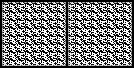

-------------
901epoch | lossD: 1.8863, lossG: 0.6931
timer:  0.4230 sec.
-------------
902epoch | lossD: 1.8849, lossG: 0.6931
timer:  0.4175 sec.
-------------
903epoch | lossD: 1.9419, lossG: 0.6931
timer:  0.4153 sec.
-------------
904epoch | lossD: 1.8711, lossG: 0.6931
timer:  0.4250 sec.
-------------
905epoch | lossD: 1.9404, lossG: 0.6931
timer:  0.4151 sec.
-------------
906epoch | lossD: 1.9138, lossG: 0.6931
timer:  0.4193 sec.
-------------
907epoch | lossD: 1.9825, lossG: 0.6931
timer:  0.4202 sec.
-------------
908epoch | lossD: 1.8845, lossG: 0.6931
timer:  0.4140 sec.
-------------
909epoch | lossD: 1.9134, lossG: 0.6931
timer:  0.4158 sec.
-------------
910epoch | lossD: 1.9260, lossG: 0.6931
timer:  0.4176 sec.
-------------
911epoch | lossD: 1.8979, lossG: 0.6931
timer:  0.4226 sec.
-------------
912epoch | lossD: 1.8979, lossG: 0.6931
timer:  0.4271 sec.
-------------
913epoch | lossD: 1.9117, lossG: 0.6931
timer:  0.4252 sec.
-------------
914epoch | lossD: 1.9138

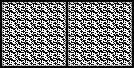

In [11]:
netD = Discriminator().to(device)
netG = Generator().to(device)

n_epochs = 1000

print('初期状態')
write(netG)
train(netD, netG, n_epochs, 100)

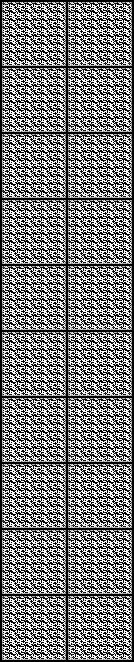

In [12]:
write(netG, 10) # 腫瘍画像を10セット描画

In [13]:
def write_from_label(netG, label, n_images=10, size=64):
    # labelに応じて腫瘍画像を描画
    labels = torch.tensor([label]*n_images).to(device)
    labels = labels.repeat_interleave(nz // n_classes, dim=-1)
    z = torch.normal(0, noise_std, size=(len(labels), nz), device=device)
    z = z + labels
    images = netG(z)
    images = transforms.Resize(size)(images)
    img = torchvision.utils.make_grid(images, len(z))
    img = transforms.functional.to_pil_image(img)
    display(img)

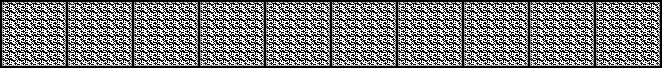

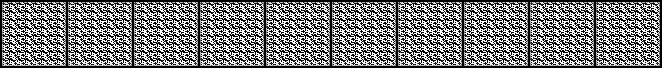

In [15]:
label = [0, 1] # metastasis
write_from_label(netG, label)
label = [0, 1] # hemangioma
write_from_label(netG, label)